# Instalar e importar las libreías necesarias

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

In [ ]:
from tqdm import tqdm
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms


import medmnist
from medmnist import INFO, Evaluator

# Definición de funciones necesarias

In [ ]:
def get_data(data_flag):
    """
    Loads datasets and returns data loaders for training, validation, and testing.

    Args:
        data_flag (str): The flag to select which dataset to load.

    Returns:
        tuple: Contains the training, validation, and test datasets, as well as their corresponding data loaders.
    """

    # Load dataset information based on data_flag
    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])

    # Define data transforms
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

    # Load datasets
    train_dataset = DataClass(split='train', transform=data_transform, download=True)
    val_dataset = DataClass(split='val', transform=data_transform, download=True)
    test_dataset = DataClass(split='test', transform=data_transform, download=True)

    # Define data loaders
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

In [ ]:
def filter_and_save(train_loader, val_loader, test_loader, label1, label2, filename):
    """
    Filters and saves images and labels from data loaders into a .mat file.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        test_loader (DataLoader): DataLoader for testing data.
        label1 (int): The first label to filter.
        label2 (int): The second label to filter.
        filename (str): The base filename for the .mat file.
    """

    train_images, train_labels = [], []
    test_images, test_labels = [], []

    # Process training data
    for img, label in train_loader:
        label = label.numpy()
        if np.any(np.isin(label, [label1, label2])):
            img = img.numpy().reshape(img.size(0), -1)  # Reshape to [N, 784]

            # Convert labels: from label1 to -1 and label2 to 1
            label = -(label == label1).astype(int) + (label == label2).astype(int)

            train_images.append(img)
            train_labels.append(label)

    # Process validationg data
    for img, label in val_loader:
        label = label.numpy()
        if np.any(np.isin(label, [label1, label2])):
            img = img.numpy().reshape(img.size(0), -1)  # Reshape to [N, 784]

            # Convert labels: from label1 to -1 and label2 to 1
            label = -(label == label1).astype(int) + (label == label2).astype(int)

            train_images.append(img)
            train_labels.append(label)

    # Process testing data
    for img, label in test_loader:
        label = label.numpy()
        if np.any(np.isin(label, [label1, label2])):
            img = img.numpy().reshape(img.size(0), -1)  # Reshape

            # Convert labels: from label1 to -1 and label2 to 1
            label = -(label == label1).astype(int) + (label == label2).astype(int)

            test_images.append(img)
            test_labels.append(label)

    # Concatenate all batches to form the full dataset
    train_images = np.concatenate(train_images, axis=0).astype(np.float64)
    train_labels = np.concatenate(train_labels, axis=0).astype(np.float64)
    test_images = np.concatenate(test_images, axis=0).astype(np.float64)
    test_labels = np.concatenate(test_labels, axis=0).astype(np.float64)

    # Save the data as a .mat file
    sio.savemat(f'{filename}.mat', {
        'data_train': train_images,
        'labels_train': train_labels,
        'data_test': test_images,
        'labels_test': test_labels
    })


# Dataset: BreastMNIST

## Descarga y visualización

In [ ]:
data_flag = 'breastmnist'
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_data(data_flag)

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 78
    Root location: /root/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'

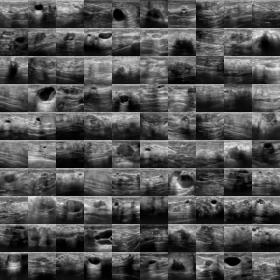

In [ ]:
train_dataset.montage(length=10)

## Preprocesamiento y descarga en formnato .mat

In [ ]:
label1 = 0
label2 = 1
filename = 'BreastMNIST'
filter_and_save(train_loader, val_loader, test_loader, label1, label2, filename)

# Dataset: DermaMNIST

## Descarga y visualización

In [ ]:
data_flag = 'dermamnist'
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = get_data(data_flag)

100%|██████████| 19725078/19725078 [00:01<00:00, 13674349.55it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 100

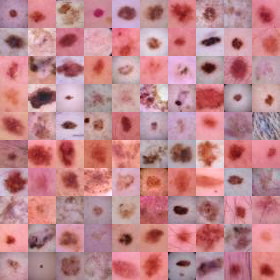

In [ ]:
train_dataset.montage(length=10)

## Preprocesamiento y descarga en formnato .mat

In [ ]:
label1 = 0
label2 = 2
filename = 'DermaMNIST_0vs2'
filter_and_save(train_loader, val_loader, test_loader, label1, label2, filename)

In [ ]:
label1 = 0
label2 = 4
filename = 'DermaMNIST_0vs4'
filter_and_save(train_loader, val_loader, test_loader, label1, label2, filename)